In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [2]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0504_norm.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,0.000,0.689,0.496,0.351,0.687,0.599,2.242,0.328,0.817,0.459,0.709,0.535,0.359,1.529,1.394,0.412,0.758,1.007,0.371,0.975,NaN,0.746,NaN,0.494,0.039,0.761,0.597,0.525,0.373,1.165,0.272,0.239,0.371,0.842,0.751,0.859,0.420,0.837,1.171,0.500
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,0.000,0.691,0.450,0.269,0.633,0.413,2.190,0.306,0.799,0.443,0.686,0.436,0.283,1.288,1.311,0.375,0.817,1.103,0.470,0.834,NaN,0.524,NaN,0.506,0.047,0.795,0.613,0.545,0.396,1.000,0.330,0.229,0.350,0.901,0.804,0.853,0.439,0.610,1.207,0.479
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,0.039,0.000,0.000,0.225,0.000,0.225,0.000,0.000,0.000,0.000,0.000,0.327,0.119,0.000,0.588,0.000,0.000,0.000,0.000,0.000,NaN,0.000,NaN,0.000,0.282,0.000,0.000,0.000,0.000,0.000,0.213,0.000,0.506,0.000,0.000,0.000,0.000,0.000,0.134,0.000
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,0.079,0.000,0.000,0.320,0.000,0.306,0.000,0.000,0.000,0.000,0.000,0.365,0.199,0.000,0.725,0.000,0.000,0.000,0.201,0.000,NaN,0.000,NaN,0.006,0.329,0.000,0.000,0.000,0.000,0.000,0.353,0.000,0.501,0.002,0.000,0.034,0.000,0.111,0.217,0.000
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,0.000,0.000,0.000,0.640,0.000,0.107,0.427,0.000,0.000,0.000,0.000,0.200,0.000,0.068,0.617,0.000,0.000,0.000,0.106,0.935,NaN,0.000,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.118,0.000,0.000,0.000,0.000,0.759,0.000,0.030,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.534,2.693,2.368,0.000,1.014,0.000,0.137,1.060,2.428,2.793,2.879,1.311,1.124,0.000,1.076,1.125,3.512,3.827,3.479,0.696,NaN,0.000,NaN,1.951,2.141,3.451,2.872,2.048,2.307,0.000,1.977,0.981,2.247,2.825,3.088,0.292,1.637,0.000,2.149,1.100
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,0.000,0.039,0.441,0.378,0.431,1.147,0.000,0.000,0.000,0.000,0.000,0.273,0.172,0.688,0.256,0.000,0.000,0.000,0.000,0.000,NaN,0.538,NaN,0.000,0.000,0.000,0.000,0.000,0.000,1.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.993,0.000,0.000
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.337,0.538,0.715,1.212,0.922,1.233,0.955,0.262,0.613,0.913,0.927,0.959,1.600,1.405,0.776,0.508,0.292,0.205,0.000,0.976,NaN,1.132,NaN,0.307,0.348,0.132,0.231,0.695,0.352,1.596,1.154,0.275,0.638,0.544,0.493,0.842,1.018,1.601,0.560,0.372
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.438,0.092,0.372,0.972,0.431,1.819,0.1

In [3]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

data_split_dict['high'] = MPRA_df[cell_types].mean(axis=1) > 1


MPRA_df['std'] = MPRA_df[cell_types].std(axis=1, skipna=True)
threshold = np.percentile(MPRA_df['std'].dropna(), 95)
data_split_dict['diff'] = (MPRA_df['std'] > threshold)
data_split_dict['const'] = ~data_split_dict['diff']


for cell_type in cell_types:
    data_split_dict[f'{cell_type}_specific'] = (MPRA_df[cell_type] - MPRA_df[cell_types].mean(axis=1)).abs() > 1

for cell_type in cell_types:
    data_split_dict[f'{cell_type}_high'] = (MPRA_df[cell_type]) > 1



# MPRA_df['diff'] = (MPRA_df[cell_types].max(axis=1) - MPRA_df[cell_types].min(axis=1)) > 1
# data_split_dict['const'] = ~MPRA_df['diff']
# data_split_dict['diff']  = MPRA_df['diff']

for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}_{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
high 79000
diff 38034
const 722645
K562_specific 25773
HepG2_specific 14562
SK-N-SH_specific 18305
HCT116_specific 6139
A549_specific 10857
K562_high 87728
HepG2_high 92456
SK-N-SH_high 81561
HCT116_high 52903
A549_high 29155


In [7]:
# seq feature
# train 3 cell types

y_pred = np.load(f'../saved/0504_Gosai_MPRA_MyResTransformer3/0504_134132/Gosai_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [8]:
# 预测值和真实值的相关性

for data_split in ['train', 'test', 'const', 'diff', 'specific', 'high']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            if data_split == 'specific' or data_split == 'high':
                condition = data_split_dict[f'{cell_type}_{data_split}']
            else:
                condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_pred] = r
    print(data_split)
    print(corr_matrix)

train
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.908      0.881        0.872       0.892     0.891
HepG2       0.904      0.936        0.909       0.917     0.924
SK-N-SH     0.889      0.900        0.922       0.903     0.906
HCT116      0.884      0.893        0.889       0.899     0.896
A549        0.795      0.813        0.817       0.822     0.824
test
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.823      0.797        0.793       0.812     0.809
HepG2       0.810      0.837        0.814       0.823     0.828
SK-N-SH     0.799      0.804        0.826       0.809     0.812
HCT116      0.810      0.817        0.813       0.828     0.824
A549        0.704      0.718        0.724       0.731     0.732
const
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.909      0.898        0.892       0.904     0.904
HepG2       0.917      0.930        0.917       0.920     0.923
SK-N-SH     0.901      

In [26]:
MPRA_df['K562-HepG2_pos'] = (MPRA_df['K562'] - MPRA_df['HepG2']) > 2
MPRA_df['K562-HepG2_neg'] = (MPRA_df['K562'] - MPRA_df['HepG2']) < -2

MPRA_df['K562-HepG2'] = MPRA_df['K562'] - MPRA_df['HepG2']
MPRA_df['K562-HepG2_pred'] = MPRA_df['K562_pred'] - MPRA_df['HepG2_pred']

<Axes: xlabel='K562-HepG2_pred', ylabel='K562-HepG2'>

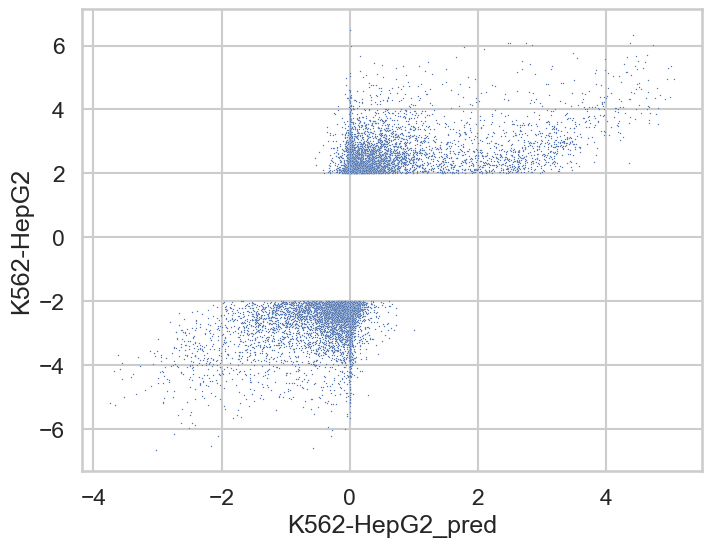

In [27]:
df = MPRA_df[MPRA_df['K562-HepG2_pos'] | MPRA_df['K562-HepG2_neg']]
x = df['K562-HepG2_pred']
y = df['K562-HepG2']
sns.scatterplot(x=x, y=y, s=1)

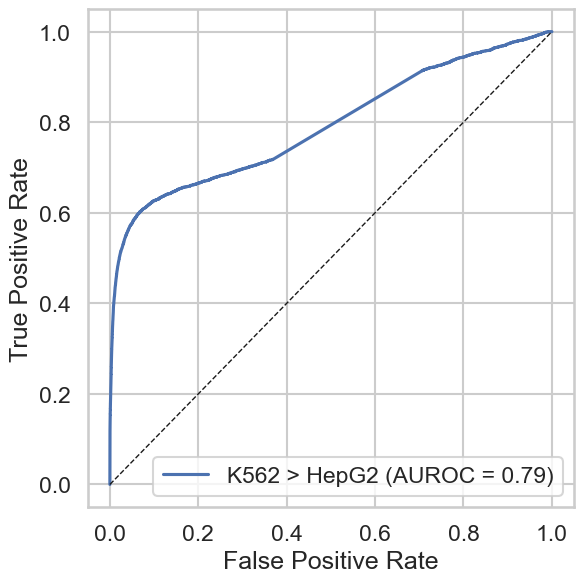

In [28]:
from sklearn.metrics import roc_curve, auc

# 正类是 K562 > HepG2 超过1
y_true_pos = MPRA_df['K562-HepG2_pos'].astype(int)
y_score_pos = MPRA_df['K562_pred'] - MPRA_df['HepG2_pred']

# # 负类是 HepG2 > K562 超过1（即 K562 < HepG2 - 1）
# y_true_neg = MPRA_df['K562-HepG2_neg'].astype(int)
# y_score_neg = MPRA_df['HepG2_pred'] - MPRA_df['K562_pred']  # 方向统一为正类打分高

# ROC for K562 > HepG2
fpr_pos, tpr_pos, _ = roc_curve(y_true_pos, y_score_pos)
auc_pos = auc(fpr_pos, tpr_pos)

# # ROC for HepG2 > K562
# fpr_neg, tpr_neg, _ = roc_curve(y_true_neg, y_score_neg)
# auc_neg = auc(fpr_neg, tpr_neg)

# Plotting
plt.figure(figsize=(6, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
plt.plot(fpr_pos, tpr_pos, label=f'K562 > HepG2 (AUROC = {auc_pos:.2f})')
# plt.plot(fpr_neg, tpr_neg, label=f'HepG2 > K562 (AUC = {auc_neg:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve: MPRA activity differential prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

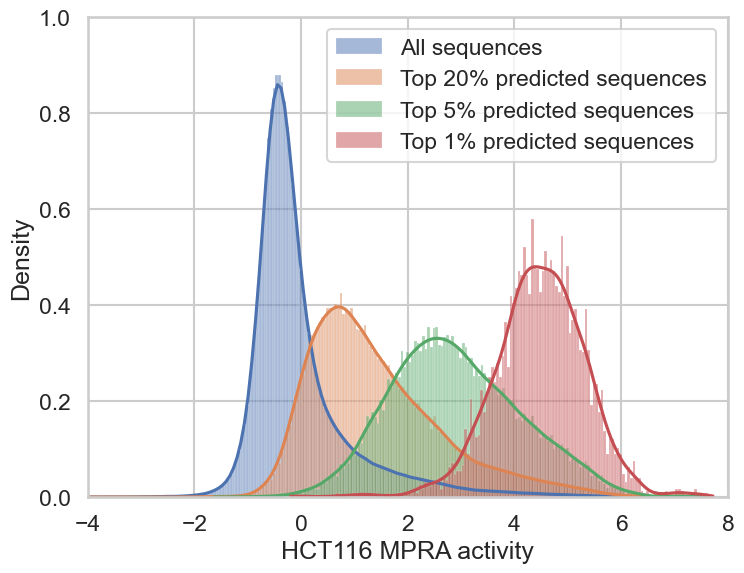

In [51]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116_pred'] > threshold]
sns.histplot(filtered_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116_pred'] > threshold]
sns.histplot(filtered_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116_pred'] > threshold]
sns.histplot(filtered_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)


plt.xlim(-4, 8)
plt.ylim(0, 1)
plt.xlabel('HCT116 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116_sequence_prioritization.png', dpi=400)

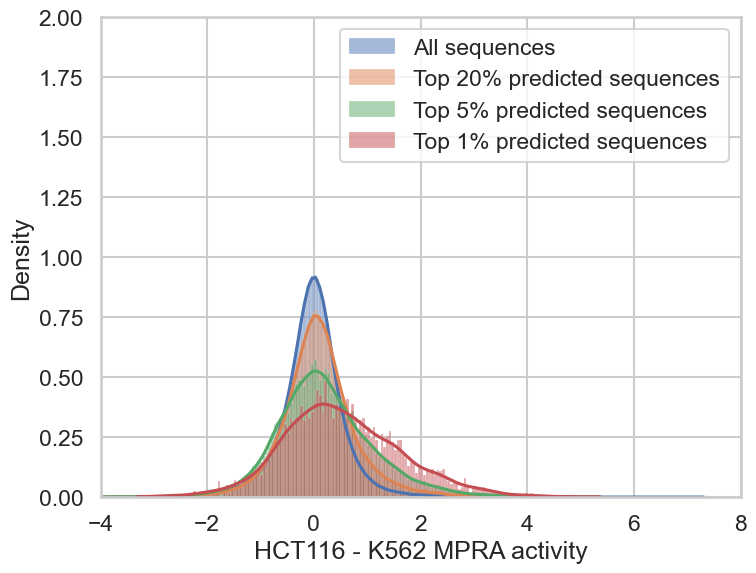

In [50]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HCT116-K562'] = MPRA_df['HCT116'] - MPRA_df['K562']
MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562_pred']


plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)

plt.xlim(-4, 8)
plt.ylim(0, 2)
plt.xlabel('HCT116 - K562 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116-K562_sequence_prioritization.png', dpi=400)

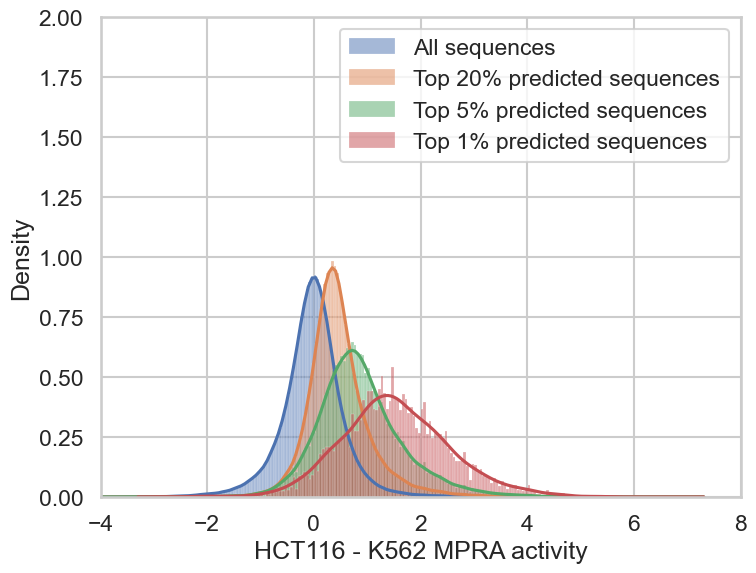

In [56]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HCT116-K562'] = MPRA_df['HCT116'] - MPRA_df['K562']
MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562']
#######MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562_pred']
#######这里我应该假设已知K562活性吗？

plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)

plt.xlim(-4, 8)
plt.ylim(0, 2)
plt.xlabel('HCT116 - K562 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116-K562_sequence_prioritization.png', dpi=400)

0.2912329242263634


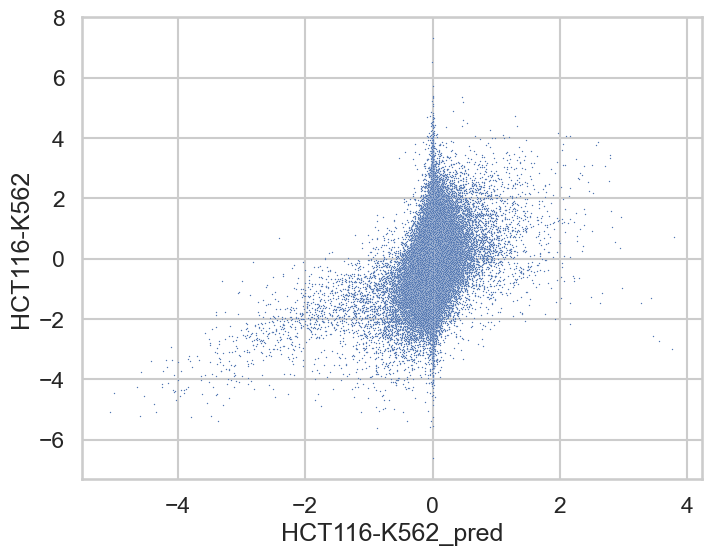

In [41]:
x=MPRA_df['HCT116-K562_pred']
y=MPRA_df['HCT116-K562']
sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)

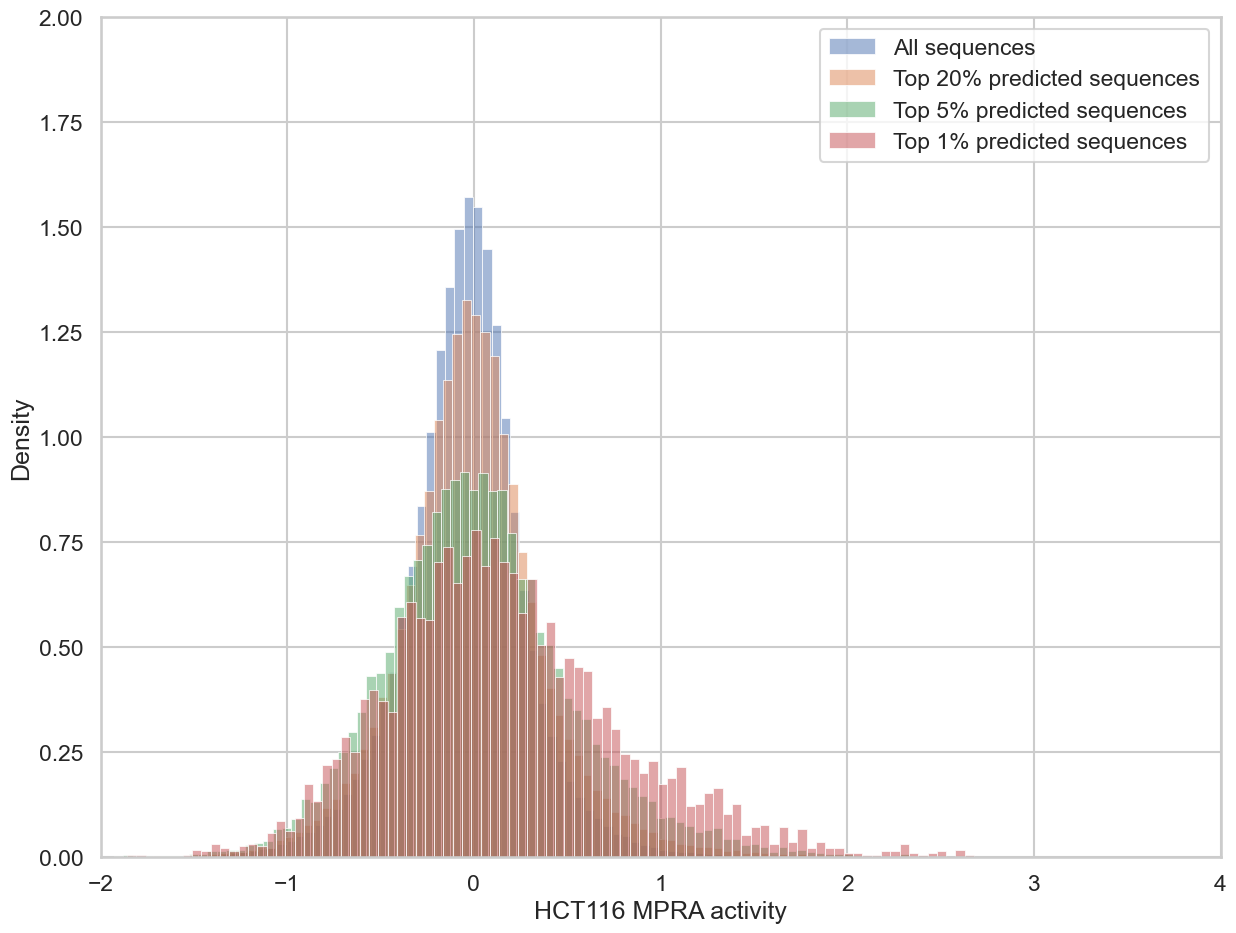

In [39]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HCT116_deviation'] = MPRA_df['HCT116'] - MPRA_df[cell_types].mean(axis=1)
MPRA_df['HCT116_pred_deviation'] = MPRA_df['HCT116_pred'] - MPRA_df[cell_types_pred].mean(axis=1)


plt.figure(figsize=(16,12), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

sns.histplot(MPRA_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences')

threshold = np.percentile(MPRA_df['HCT116_pred_deviation'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116_pred_deviation'] > threshold]
sns.histplot(filtered_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences')

threshold = np.percentile(MPRA_df['HCT116_pred_deviation'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116_pred_deviation'] > threshold]
sns.histplot(filtered_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences')

threshold = np.percentile(MPRA_df['HCT116_pred_deviation'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116_pred_deviation'] > threshold]
sns.histplot(filtered_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences')

plt.xlim(-2, 4)
plt.ylim(0, 2)
plt.xlabel('HCT116 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116_deviation_sequence_prioritization.png', dpi=400)